In [60]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))


import numpy as np
from scipy.optimize import minimize
import networkx as nx

import qiskit 
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from shared.QiskitMaxcut import *
from qiskit.utils import QuantumInstance
from qiskit.result import Result
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.algorithms.optimizers import SPSA, COBYLA, QNSPSA
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
%matplotlib inline

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')
# https://arxiv.org/pdf/2011.10860.pdf

ibmqfactory.load_account:WARNING:2021-09-07 12:32:31,048: Credentials are already in use. The existing account in the session will be replaced.


In [61]:
from shared.graph_helper import load_nx_graph_from, generate_butterfly_graph

In [62]:
from qiskit.providers import Backend, BaseBackend
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.layout import Layout
from qiskit.assembler.run_config import RunConfig
from qiskit.circuit import QuantumCircuit
from qiskit.result import Result
from qiskit.qobj import Qobj
from qiskit import compiler
from qiskit.converters import circuit_to_dag, dag_to_circuit

from typing import Optional, List, Union, Dict, Callable, Tuple
import itertools, copy 
import copy
import logging
from time import time
import numpy as np
import re


class GEMQuantumInstance(QuantumInstance):
        
    def get_freq_vector(self, result):
        
        counts = result.get_counts().copy()
        n = len(result.results[0].header.clbit_labels)#//2
        shots = self._run_config.shots
        # es kann sein, dass nicht immer alle combis in counts sind, deswegen: 
        combinations = list(map(list, itertools.product([0, 1], repeat=n)))
        freqs = {}
        for comb in combinations: # init dict
            freqs[re.sub('[^01]', '', str(comb))] = 0
        
        v = []
        for key in sorted(counts):
            freqs[key] = counts[key] / shots
            
        for key in sorted(freqs):
            v.append( freqs[key] )
    
        return v.copy()
        
    
    def apply_gem(self, v, MG):
        # scipy minimize 
        constraints = (
            {'type': 'eq', 'fun': lambda x: sum(x) - 1},
        )
        bounds = tuple([(0,1) for _ in range(0,len(v))])

        X = np.random.rand(len(v))
        
        # minimize cost function 
        def cost_function(X, V, M):
            cost = 0
            MX = M @ X  
            for i in range(0, len(V)):
                v = V[i]
                cost += ( v - MX[i] ) ** 2
            return cost

        res = minimize(cost_function, X, method='SLSQP', args=(v, MG), 
                       constraints=constraints, bounds=bounds,
                       options={'gtol': 1e-6, 'disp': False})

        return res.x
    
    def convert_to_counts(self, freqs, counts):
        freqs = freqs * self._run_config.shots
        i = 0
        for key in sorted(counts):
            counts[key] = int( np.round(freqs[i]) )
            i  += 1
        return counts

    def execute(self,
                circuits: Union[QuantumCircuit, List[QuantumCircuit]],
                had_transpiled: bool = False) -> Result:
            
        if hasattr(self, 'MG') is False:
            return super().execute(circuits, had_transpiled)
        if self.MG is None: 
               return super().execute(circuits, had_transpiled) 

        # execute original circuit
        #print("execute original circuit")
        
        # print(circuits[0])
        result = super().execute(circuits, had_transpiled)
        v = self.get_freq_vector(result)
        
        # apply gem and get mitigated v 
        x = self.apply_gem(v, self.MG)
        
        # convert freqs to counts 
        mitigated_counts = self.convert_to_counts(x, result.get_counts().copy())
        
        # replace previous counts with mitigated counts 
        result.results[0].data.counts = mitigated_counts
        
        return result

In [63]:
from qiskit.providers import Backend, BaseBackend
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.layout import Layout
from qiskit.assembler.run_config import RunConfig
from qiskit.circuit import QuantumCircuit
from qiskit.result import Result
from qiskit.qobj import Qobj
from qiskit import compiler
from qiskit.converters import circuit_to_dag, dag_to_circuit

from typing import Optional, List, Union, Dict, Callable, Tuple
import itertools, copy 
import copy
import logging
from time import time
import numpy as np
import re

class GEM():
    
    def __init__(self, MG=None, quantum_instance=None):
        self.MG = MG 
        self.quantum_instance = quantum_instance
    
    
    def split(self, dag_qc, layers):
        for layer in layers:
            for node in layer:
                if node.type == 'op':
                    dag_qc.remove_op_node(node)

        return dag_to_circuit(dag_qc)


    def split_circuit(self, qc):
        layers = list(circuit_to_dag(qc).multigraph_layers())

        # calculate separation point 
        n_remove = 0
        if len(layers) % 2 == 0: # even
            n_remove = len(layers) // 2
        else: # odd 
            n_remove = (len(layers) - 1) // 2

        # split circuits
        # https://quantumcomputing.stackexchange.com/a/13824/16704 : 
        # the extra minus 1 since the last layer consists of output nodes (qubits and clbits).
        first_half_qc = self.split(circuit_to_dag(qc), layers[- n_remove -1 :])
        second_half_qc = self.split(circuit_to_dag(qc), layers[:- n_remove -1])

        return first_half_qc, second_half_qc
    
    def inverse_and_compose(self, circuit):
        return circuit.copy().compose(circuit.inverse())
    
    
    def prepare_circuits(self, n_qubits):
        start_states = list(map(list, itertools.product([0, 1], repeat=n_qubits)))
        circuits = []
        for state in start_states:
            circuit = QuantumCircuit(n_qubits, n_qubits)
            for i,v in enumerate(state):
                if v == 1:
                    circuit.x(i)

            circuits.append(circuit)

        return circuits.copy()
    
    def compose_circuits(self, prepared, inversed):
        qcs = []
        for pc in prepared:
            qc = pc.copy().compose(inversed)
            qc.measure_all()
            qcs.append(qc.copy())
        
        return qcs
    
        
    def _hex_to_bin(self, hexstring):
        """Convert hexadecimal readouts (memory) to binary readouts."""
        return str(bin(int(hexstring, 16)))[2:]

    def _pad_zeros(self, bitstring, memory_slots):
        """If the bitstring is truncated, pad extra zeros to make its
        length equal to memory_slots"""
        return format(int(bitstring, 2), f"0{memory_slots}b")

    def _separate_bitstring(self, bitstring, creg_sizes):
        """Separate a bitstring according to the registers defined in the result header."""
        substrings = []
        running_index = 0
        for _, size in reversed(creg_sizes):
            substrings.append(bitstring[running_index : running_index + size])
            running_index += size
        return " ".join(substrings)

    def format_counts_memory(self, shot_memory, header=None):
        """
        Format a single bitstring (memory) from a single shot experiment.
        - The hexadecimals are expanded to bitstrings
        - Spaces are inserted at register divisions.
        Args:
            shot_memory (str): result of a single experiment.
            header (dict): the experiment header dictionary containing
                useful information for postprocessing. creg_sizes
                are a nested list where the inner element is a list
                of creg name, creg size pairs. memory_slots is an integers
                specifying the number of total memory_slots in the experiment.
        Returns:
            dict: a formatted memory
        """
        if shot_memory.startswith("0x"):
            shot_memory = self._hex_to_bin(shot_memory)
        if header:
            creg_sizes = header.creg_sizes
            memory_slots = header.memory_slots
            if memory_slots:
                shot_memory = self._pad_zeros(shot_memory, memory_slots)
            if creg_sizes and memory_slots:
                shot_memory = self._separate_bitstring(shot_memory, creg_sizes)
        return shot_memory

    def my_format_counts(self, counts, header=None):
        """Format a single experiment result coming from backend to present
        to the Qiskit user.
        Args:
            counts (dict): counts histogram of multiple shots
            header (dict): the experiment header dictionary containing
                useful information for postprocessing.
        Returns:
            dict: a formatted counts
        """
        counts_dict = {}
        for key, val in counts.items():
            key = self.format_counts_memory(key, header)
            counts_dict[key] = val
        return counts_dict
    

    def calculate_freq(self, result):
        n = len(result.header.clbit_labels)//2
        shots = result.shots
        #print(n)
        #print(result)
        combinations = list(map(list, itertools.product([0, 1], repeat=n)))
        freqs = {}
        for comb in combinations: # init dict
            freqs[re.sub('[^01]', '', str(comb))] = 0.0

        counts = self.my_format_counts(result.data.counts, result.header)
        for count in counts.items():
            bitstr, values = count
            if (bitstr == '0'):
                bitstr = '0'*n
            bitstr = bitstr.replace(' ','')
            bitstr = bitstr[:n][::-1]
            freqs[bitstr] = values / shots

        return list(freqs.values())
    
    def create_m(self, results):
        
        m = np.expand_dims( np.array(self.calculate_freq(results[0])), axis=1)
        for result in results[1:]:
            v = np.expand_dims( np.array(self.calculate_freq(result)), axis=1)
            m = np.append(m, v, axis=1)
        return m
    
    def create_m_matrix(self, circuit, n_qubits, had_transpiled) -> np.array:
         # inverse and compose each circuit
        inversed_circuit = self.inverse_and_compose(circuit)
    
        # prepare calibration circuits
        prepared_circuits  = self.prepare_circuits(n_qubits)

        # compose prepared with inversed ones
        calibration_circuits = self.compose_circuits(prepared_circuits, inversed_circuit)
        
        # execute calibration circuits
        result = self.quantum_instance.execute(calibration_circuits, had_transpiled)
        m = self.create_m(result.results)
        
        return m
    

    def construct_gem(self, circuit, quantum_instance):
        
        #print("construct_gem")
        
        if self.MG is not None:
            #print("use cached MG")
            return self.MG.copy()
        
        if quantum_instance is None:
            raise Exception("NO quantum_instance")
        self.quantum_instance = quantum_instance  
        
        #print("MG is None: calculate MG")
        
        # remove measure gates 
        #print("remove measure gates ")
        while circuit.data[-1][0].name == 'measure':
            circuit.data.pop()

        n_qubits = circuit.num_qubits
        #print(f"Number of Qubits: {n_qubits}")

        # split circuit in half
        #print("split circuit in half")
        first_half_qc, second_half_qc = self.split_circuit(circuit)

        # calculate M-Matrices
        #print("calculate M-Matrices: ", end='')
        had_transpiled = False
        M1 = self.create_m_matrix(first_half_qc, n_qubits, had_transpiled)
        M2 = self.create_m_matrix(second_half_qc, n_qubits, had_transpiled)

        # calculate MG-Matrix
        MG = (M1 + M2) / 2

        self.MG = MG.copy()
        
        #print("done\n")
        
        return self.MG

In [75]:
class GEMMinimumEigenOptimizer(MinimumEigenOptimizer):
    def solve_with_gem(self, problem: QuadraticProgram, gem: GEM):
        
        #print("solve_with_gem")
        
        self._verify_compatibility(problem)

        # convert problem to QUBO
        problem_ = self._convert(problem, self._converters)

        # construct operator and offset
        operator, offset = problem_.to_ising()
        
        # check and validate points and ansatz
        self._min_eigen_solver._check_operator_ansatz(operator)
        initial_point = _validate_initial_point(self._min_eigen_solver._initial_point, self._min_eigen_solver.ansatz)
        bounds = _validate_bounds(self._min_eigen_solver.ansatz)
        
        # construct circuit 
        param_dict = dict(zip(self._min_eigen_solver._ansatz_params, initial_point))  # type: Dict
        circuit = self._min_eigen_solver.ansatz.assign_parameters(param_dict)
        
        # calculate MG Matrix 
        MG = gem.construct_gem(circuit, self._min_eigen_solver.quantum_instance)
        
        # set MG to quantum instance
        self._min_eigen_solver.quantum_instance.MG = MG
        
        return self.solve(problem)

def _validate_initial_point(point, ansatz):
    expected_size = ansatz.num_parameters

    # try getting the initial point from the ansatz
    if point is None and hasattr(ansatz, "preferred_init_points"):
        point = ansatz.preferred_init_points
    # if the point is None choose a random initial point

    if point is None:
        # get bounds if ansatz has them set, otherwise use [-2pi, 2pi] for each parameter
        bounds = getattr(ansatz, "parameter_bounds", None)
        if bounds is None:
            bounds = [(-2 * np.pi, 2 * np.pi)] * expected_size

        # replace all Nones by [-2pi, 2pi]
        lower_bounds = []
        upper_bounds = []
        for lower, upper in bounds:
            lower_bounds.append(lower if lower is not None else -2 * np.pi)
            upper_bounds.append(upper if upper is not None else 2 * np.pi)

        # sample from within bounds
        point = algorithm_globals.random.uniform(lower_bounds, upper_bounds)

    elif len(point) != expected_size:
        raise ValueError(
            f"The dimension of the initial point ({len(point)}) does not match the "
            f"number of parameters in the circuit ({expected_size})."
        )

    return point


def _validate_bounds(ansatz):
    if hasattr(ansatz, "parameter_bounds") and ansatz.parameter_bounds is not None:
        bounds = ansatz.parameter_bounds
        if len(bounds) != ansatz.num_parameters:
            raise ValueError(
                f"The number of bounds ({len(bounds)}) does not match the number of "
                f"parameters in the circuit ({ansatz.num_parameters})."
            )
    else:
        bounds = [(None, None)] * ansatz.num_parameters

    return bounds   

In [65]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

noise_backend = provider.get_backend("ibmq_toronto")
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [66]:
def display_mean_and_std(means, ars):
    print(f"Number of Evaluations: {n_evaluations}")
    print(f"Mean of Mean: {np.round(np.mean(means), 4)}, Std: {np.round(np.std(means), 4)}, Median: {np.round( np.median(means),4)}")
    print(f"Mean of Approx. Ratio: {np.round(np.mean(ars), 4)}, Std: {np.round(np.std(ars), 4)}, Median: {np.round( np.median(ars),4)}")

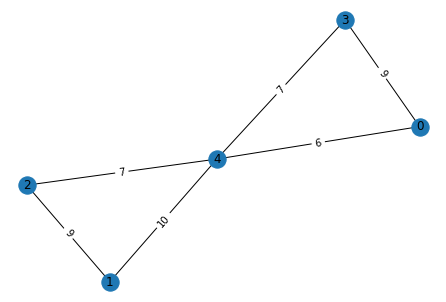

In [67]:
G = generate_butterfly_graph()
max_cut = Maxcut(G,-35)
max_cut.draw()
qubo = max_cut.to_qubo()

In [68]:
# Minimum 
initial_point=[ -2.34,-2.94/2 ]

In [69]:
maxiter=0
shots=8192
reps=1
n_evaluations = 1

# Simulator with Noise Model

### GEM

In [70]:
gem = GEM()

In [76]:
gem_means = []
gem_ars = []
for e in range(0,n_evaluations):
    # QAOA with GEM
    qiGME = GEMQuantumInstance(backend=Aer.get_backend('qasm_simulator'),
                               #noise_model=noise_model, 
                               #coupling_map=coupling_map,
                               #basis_gates=basis_gates,
                               shots=shots)
    qaoa = QAOA(quantum_instance=qiGME, reps=reps, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))

    result = GEMMinimumEigenOptimizer(qaoa).solve_with_gem(qubo, gem)
    mean, r, ar = max_cut.analyse_evaluation(result, print_output=False)
    gem_means.append(mean)
    gem_ars.append(ar)

In [54]:
display_mean_and_std(gem_means, gem_ars)

Number of Evaluations: 20
Mean of Mean: -29.2761, Std: 1.2251, Median: -28.8786
Mean of Approx. Ratio: 0.8365, Std: 0.035, Median: 0.8251


### EM

In [55]:
em_means = []
em_ars = []
for e in range(0,n_evaluations):
    qi = QuantumInstance(backend=Aer.get_backend('qasm_simulator'),
                         noise_model=noise_model, 
                         coupling_map=coupling_map,
                         basis_gates=basis_gates,
                         measurement_error_mitigation_cls=CompleteMeasFitter,
                         measurement_error_mitigation_shots=shots,
                         shots=shots)
    qaoa = QAOA(quantum_instance=qi,reps=reps, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(qubo)
    mean, r, ar = max_cut.analyse_evaluation(result, print_output=False)
    em_means.append(mean)
    em_ars.append(ar)


In [56]:
display_mean_and_std(em_means, em_ars)

Number of Evaluations: 20
Mean of Mean: -27.4194, Std: 1.1208, Median: -27.0764
Mean of Approx. Ratio: 0.7834, Std: 0.032, Median: 0.7736


### No Mitigation

In [57]:
means = []
ars = []
for e in range(0,n_evaluations):
    qi = QuantumInstance(backend=Aer.get_backend('qasm_simulator'),
                         noise_model=noise_model, 
                         coupling_map=coupling_map,
                         basis_gates=basis_gates,
                         shots=shots)
    qaoa = QAOA(quantum_instance=qi,reps=reps, initial_point=initial_point, optimizer=COBYLA(maxiter=maxiter))
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(qubo)
    mean, r, ar = max_cut.analyse_evaluation(result, print_output=False)
    means.append(mean)
    ars.append(ar)

In [58]:
display_mean_and_std(means, ars)

Number of Evaluations: 20
Mean of Mean: -27.2913, Std: 0.7769, Median: -27.1104
Mean of Approx. Ratio: 0.7798, Std: 0.0222, Median: 0.7746


## Results 

In [59]:
print("GEM: ")
display_mean_and_std(gem_means, gem_ars)
print()
print("EM: ")
display_mean_and_std(em_means, em_ars)
print()
print("No Error Mitigation: ")
display_mean_and_std(means, ars)

GEM: 
Number of Evaluations: 20
Mean of Mean: -29.2761, Std: 1.2251, Median: -28.8786
Mean of Approx. Ratio: 0.8365, Std: 0.035, Median: 0.8251

EM: 
Number of Evaluations: 20
Mean of Mean: -27.4194, Std: 1.1208, Median: -27.0764
Mean of Approx. Ratio: 0.7834, Std: 0.032, Median: 0.7736

No Error Mitigation: 
Number of Evaluations: 20
Mean of Mean: -27.2913, Std: 0.7769, Median: -27.1104
Mean of Approx. Ratio: 0.7798, Std: 0.0222, Median: 0.7746
